simple autorec on movielens, best combination of hyperparameters to be determined at the end

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt


In [2]:
import pandas as pd

# Load MovieLens data
ratings_data = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'])
movies_data = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'genres'])

# Merge the ratings and movies dataframes to include movie titles in the ratings dataframe
merged_data = pd.merge(ratings_data, movies_data, on='movieId')

# Count the number of ratings for each movie
movie_rating_counts = ratings_data['movieId'].value_counts()

# Get the top 3000 movies
top_5000_movie_ids = movie_rating_counts.head(5000).index

# Filter the ratings to keep only those from the top 3000 movies
filtered_ratings_data = ratings_data[ratings_data['movieId'].isin(top_5000_movie_ids)]

# Get the users who have rated these top 3000 movies
users_with_top_movie_ratings = filtered_ratings_data['userId'].unique()

# Filter the ratings to keep only those from these users
filtered_ratings_data = filtered_ratings_data[filtered_ratings_data['userId'].isin(users_with_top_movie_ratings)]

# Function to get reviews for a specific user and include movie titles
def get_user_reviews(user_id, data):
    user_reviews = data[data['userId'] == user_id]
    return user_reviews

# Select a specific user ID
specific_user_id = 1  # You can change this to any user ID you want

# Get the reviews for the specific user
user_reviews = get_user_reviews(specific_user_id, filtered_ratings_data)

# Check if there are any reviews for this user
if not user_reviews.empty:
    print(f"Reviews for user {specific_user_id}:")
    user_reviews = pd.merge(user_reviews, movies_data, on='movieId')
    print(user_reviews[['userId', 'movieId', 'rating', 'title']])
else:
    print(f"No reviews found for user {specific_user_id}.")

# Check if the specific user ID exists in the original ratings dataframe
print(f"Does user ID {specific_user_id} exist in the original DataFrame? {'Yes' if specific_user_id in ratings_data['userId'].values else 'No'}")


Reviews for user 1:
    userId  movieId  rating                                              title
0        1      296     5.0                                Pulp Fiction (1994)
1        1      306     3.5   Three Colors: Red (Trois couleurs: Rouge) (1994)
2        1      307     5.0   Three Colors: Blue (Trois couleurs: Bleu) (1993)
3        1      665     5.0                                 Underground (1995)
4        1      899     3.5                         Singin' in the Rain (1952)
5        1     1088     4.0                               Dirty Dancing (1987)
6        1     1175     3.5                                Delicatessen (1991)
7        1     1217     3.5                                         Ran (1985)
8        1     1237     5.0    Seventh Seal, The (Sjunde inseglet, Det) (1957)
9        1     1250     4.0               Bridge on the River Kwai, The (1957)
10       1     1260     3.5                                           M (1931)
11       1     1653     4.0     

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
ratings_data = filtered_ratings_data

# Check unique user and movie IDs before factorization
unique_user_ids = ratings_data['userId'].nunique()
unique_movie_ids = ratings_data['movieId'].nunique()
print(f"Unique userIds before factorization: {unique_user_ids}")
print(f"Unique movieIds before factorization: {unique_movie_ids}")

# Ensure specific user ID exists in the original DataFrame
specific_user_id = 1  # Change to the desired user ID
print(f"Does user ID {specific_user_id} exist in the original DataFrame? {'Yes' if specific_user_id in ratings_data['userId'].values else 'No'}")

# Factorize user and movie IDs
user_id_mapping, user_unique_ids = pd.factorize(ratings_data['userId'])
movie_id_mapping, movie_unique_ids = pd.factorize(ratings_data['movieId'])

# Create DataFrame to map factorized IDs back to original IDs
user_id_map_df = pd.DataFrame({'original_user_id': user_unique_ids, 'factorized_user_id': range(len(user_unique_ids))})
movie_id_map_df = pd.DataFrame({'original_movie_id': movie_unique_ids, 'factorized_movie_id': range(len(movie_unique_ids))})

# Debugging: Check if the specific user ID is in the unique user IDs
print(f"Is specific user ID {specific_user_id} in unique user IDs? {'Yes' if specific_user_id in user_unique_ids else 'No'}")

# Replace the original IDs with the factorized IDs
ratings_data['userId'] = user_id_mapping
ratings_data['movieId'] = movie_id_mapping

# Check unique user and movie IDs after factorization
unique_user_ids_after = ratings_data['userId'].nunique()
unique_movie_ids_after = ratings_data['movieId'].nunique()
print(f"Unique userIds after factorization: {unique_user_ids_after}")
print(f"Unique movieIds after factorization: {unique_movie_ids_after}")

# Get max user and movie IDs
max_user_id = user_id_mapping.max() + 1
max_movie_id = movie_id_mapping.max() + 1
print(f"Max movie id: {max_movie_id}, Max user id: {max_user_id}")

# Normalize ratings
min_rating = ratings_data['rating'].min()
max_rating = ratings_data['rating'].max()
ratings_data['rating'] = (ratings_data['rating'] - min_rating) / (max_rating - min_rating)

# Create the user-item matrix and the mask matrix
data = ratings_data['rating'].values
rows = ratings_data['userId'].values
cols = ratings_data['movieId'].values

user_item_matrix = csr_matrix((data, (rows, cols)), shape=(max_user_id, max_movie_id))
genuine_ratings_mask = csr_matrix((np.ones_like(data), (rows, cols)), shape=(max_user_id, max_movie_id))

print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"User-item matrix non-zero count: {user_item_matrix.nnz}")
print(f"Mask matrix shape: {genuine_ratings_mask.shape}")
print(f"Mask matrix non-zero count: {genuine_ratings_mask.nnz}")

# Helper functions to map factorized IDs back to original IDs
def factorized_to_original_user_id(factorized_id):
    return user_id_map_df.loc[user_id_map_df['factorized_user_id'] == factorized_id, 'original_user_id'].values[0]

def factorized_to_original_movie_id(factorized_id):
    return movie_id_map_df.loc[movie_id_map_df['factorized_movie_id'] == factorized_id, 'original_movie_id'].values[0]

def original_to_factorized_user_id(original_id):
    if original_id in user_id_map_df['original_user_id'].values:
        return user_id_map_df.loc[user_id_map_df['original_user_id'] == original_id, 'factorized_user_id'].values[0]
    else:
        print(f"Original user ID {original_id} not found.")
        return None

def original_to_factorized_movie_id(original_id):
    if original_id in movie_id_map_df['original_movie_id'].values:
        return movie_id_map_df.loc[movie_id_map_df['original_movie_id'] == original_id, 'factorized_movie_id'].values[0]
    else:
        print(f"Original movie ID {original_id} not found.")
        return None

# Map to factorized ID
factorized_user_id = original_to_factorized_user_id(specific_user_id)
# Debugging: Check if the specific user ID is in the unique user IDs
print(f"Is specific user ID {specific_user_id} in unique user IDs? {'Yes' if specific_user_id in user_unique_ids else 'No'}")

if factorized_user_id is not None:
    # Extract user's reviews from the user-item matrix
    user_ratings = user_item_matrix.getrow(factorized_user_id).toarray().flatten()
    rated_movie_indices = np.where(user_ratings > 0)[0]
    ratings = user_ratings[rated_movie_indices]

    # Map factorized movie IDs back to original IDs
    original_movie_ids = [factorized_to_original_movie_id(movie_id) for movie_id in rated_movie_indices]

    # Get movie titles using the original movie IDs
    movie_titles = movies_data[movies_data['movieId'].isin(original_movie_ids)]

    # Print the results
    print(f"Reviews for user {specific_user_id} (Factorized ID: {factorized_user_id}):")
    for original_movie_id, rating in zip(original_movie_ids, ratings):
        movie_title = movie_titles[movie_titles['movieId'] == original_movie_id]['title'].values[0]
        print(f"Movie: {movie_title}, Original Movie ID: {original_movie_id}, Rating: {rating * (max_rating - min_rating) + min_rating}")
else:
    print(f"Factorized user ID for {specific_user_id} not found.")


Unique userIds before factorization: 162539
Unique movieIds before factorization: 5000
Does user ID 1 exist in the original DataFrame? Yes
Is specific user ID 1 in unique user IDs? Yes
Unique userIds after factorization: 162539
Unique movieIds after factorization: 5000
Max movie id: 5000, Max user id: 162539
User-item matrix shape: (162539, 5000)
User-item matrix non-zero count: 23062613
Mask matrix shape: (162539, 5000)
Mask matrix non-zero count: 23062613
Is specific user ID 1 in unique user IDs? Yes
Reviews for user 1 (Factorized ID: 0):
Movie: Pulp Fiction (1994), Original Movie ID: 296, Rating: 5.0
Movie: Three Colors: Red (Trois couleurs: Rouge) (1994), Original Movie ID: 306, Rating: 3.5
Movie: Three Colors: Blue (Trois couleurs: Bleu) (1993), Original Movie ID: 307, Rating: 5.0
Movie: Underground (1995), Original Movie ID: 665, Rating: 5.0
Movie: Singin' in the Rain (1952), Original Movie ID: 899, Rating: 3.5
Movie: Dirty Dancing (1987), Original Movie ID: 1088, Rating: 4.0
Mov

In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

# Split the data
train_indices, test_indices = train_test_split(np.arange(user_item_matrix.shape[0]), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

print(f"Is factorized user ID {factorized_user_id} in training indices? {'Yes' if factorized_user_id in train_indices else 'No'}")
print(f"Is factorized user ID {factorized_user_id} in validation indices? {'Yes' if factorized_user_id in val_indices else 'No'}")
print(f"Is factorized user ID {factorized_user_id} in test indices? {'Yes' if factorized_user_id in test_indices else 'No'}")

# Create datasets
class CSRDataset(Dataset):
    def __init__(self, user_item_matrix, mask_matrix, indices):
        self.user_item_matrix = user_item_matrix
        self.mask_matrix = mask_matrix
        self.indices = indices
        print(f"Dataset initialized with {len(self.indices)} users.")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        user_idx = self.indices[idx]
        dense_row = self.user_item_matrix[user_idx].toarray().squeeze(0)
        mask_row = self.mask_matrix[user_idx].toarray().squeeze(0)
        dense_tensor = torch.from_numpy(dense_row).float()
        mask_tensor = torch.from_numpy(mask_row).float()
        return dense_tensor, mask_tensor

train_dataset = CSRDataset(user_item_matrix, genuine_ratings_mask, train_indices)
val_dataset = CSRDataset(user_item_matrix, genuine_ratings_mask, val_indices)
test_dataset = CSRDataset(user_item_matrix, genuine_ratings_mask, test_indices)

# Function to extract ratings and corresponding mask values for a user
def get_user_data(dataset, user_id):
    for idx in range(len(dataset)):
        user_idx = dataset.indices[idx]
        if user_idx == user_id:
            dense_tensor, mask_tensor = dataset[idx]
            user_ratings = dense_tensor.numpy()
            user_mask = mask_tensor.numpy()
            return user_ratings, user_mask
    return None, None

# Get the data for the specific user
user_ratings, user_mask = get_user_data(val_dataset, factorized_user_id)

if user_ratings is not None and user_mask is not None:
    # Filter out the indices where the mask is non-zero
    mask_non_zero_indices = np.nonzero(user_mask)[0]
    mask_non_zero_ratings = user_ratings[mask_non_zero_indices]
    mask_non_zero_mask = user_mask[mask_non_zero_indices]

    # Print results
    print(f"Indices with non-zero mask values: {mask_non_zero_indices}")
    print(f"Ratings at these indices: {mask_non_zero_ratings}")
    print(f"Mask values at these indices: {mask_non_zero_mask}")
else:
    print(f"User {factorized_user_id} not found in the validation dataset.")


Is factorized user ID 0 in training indices? No
Is factorized user ID 0 in validation indices? No
Is factorized user ID 0 in test indices? Yes
Dataset initialized with 97523 users.
Dataset initialized with 32508 users.
Dataset initialized with 32508 users.
User 0 not found in the validation dataset.


In [5]:
import torch
from torch.utils.data import DataLoader

# Function to find and print a specific user's data from the CSRDataset
def check_integrity_of_dataset(dataset, factorized_user_id, dataset_name):
    found = False
    for idx in range(len(dataset)):
        user_idx = dataset.indices[idx]
        if user_idx == factorized_user_id:
            dense_tensor, mask_tensor = dataset[idx]
            user_ratings = dense_tensor.numpy()
            user_mask = mask_tensor.numpy()

            rated_movie_indices = np.where(user_mask > 0)[0]
            ratings = user_ratings[rated_movie_indices]

            if len(ratings) > 0:
                found = True
                # Map factorized movie IDs back to original IDs
                original_movie_ids = [factorized_to_original_movie_id(movie_id) for movie_id in rated_movie_indices]

                # Get movie titles using the original movie IDs
                movie_titles = movies_data[movies_data['movieId'].isin(original_movie_ids)]

                # Print the results
                print(f"{dataset_name} - Reviews for user {specific_user_id} (Factorized ID: {factorized_user_id}):")
                for original_movie_id, rating in zip(original_movie_ids, ratings):
                    movie_title = movie_titles[movie_titles['movieId'] == original_movie_id]['title'].values[0]
                    print(f"Movie: {movie_title}, Original Movie ID: {original_movie_id}, Rating: {rating * (max_rating - min_rating) + min_rating}")
                break

    if not found:
        print(f"User {factorized_user_id} not found in {dataset_name} dataset.")

# Map the specific original user ID to the factorized user ID
specific_user_id = 1  # Change this to the desired user ID
factorized_user_id = original_to_factorized_user_id(specific_user_id)

if factorized_user_id is not None:
    # Check the integrity of the datasets
    check_integrity_of_dataset(train_dataset, factorized_user_id, "Train")
    check_integrity_of_dataset(val_dataset, factorized_user_id, "Validation")
    check_integrity_of_dataset(test_dataset, factorized_user_id, "Test")
else:
    print(f"Factorized user ID for {specific_user_id} not found.")


User 0 not found in Train dataset.
User 0 not found in Validation dataset.
Test - Reviews for user 1 (Factorized ID: 0):
Movie: Pulp Fiction (1994), Original Movie ID: 296, Rating: 5.0
Movie: Three Colors: Red (Trois couleurs: Rouge) (1994), Original Movie ID: 306, Rating: 3.500000089406967
Movie: Three Colors: Blue (Trois couleurs: Bleu) (1993), Original Movie ID: 307, Rating: 5.0
Movie: Underground (1995), Original Movie ID: 665, Rating: 5.0
Movie: Singin' in the Rain (1952), Original Movie ID: 899, Rating: 3.500000089406967
Movie: Dirty Dancing (1987), Original Movie ID: 1088, Rating: 4.000000059604645
Movie: Delicatessen (1991), Original Movie ID: 1175, Rating: 3.500000089406967
Movie: Ran (1985), Original Movie ID: 1217, Rating: 3.500000089406967
Movie: Seventh Seal, The (Sjunde inseglet, Det) (1957), Original Movie ID: 1237, Rating: 5.0
Movie: Bridge on the River Kwai, The (1957), Original Movie ID: 1250, Rating: 4.000000059604645
Movie: M (1931), Original Movie ID: 1260, Rating:

MovieLens Train Loader - First batch info:
Batch shape: torch.Size([128, 5000])
Batch type: torch.float32
Mask shape: torch.Size([128, 5000])
Mask type: torch.float32
Number of samples in batch: 128
MovieLens Validation Loader - First batch info:
Batch shape: torch.Size([128, 5000])
Batch type: torch.float32
Mask shape: torch.Size([128, 5000])
Mask type: torch.float32
Number of samples in batch: 128
MovieLens Test Loader - First batch info:
Batch shape: torch.Size([128, 5000])
Batch type: torch.float32
Mask shape: torch.Size([128, 5000])
Mask type: torch.float32
Number of samples in batch: 128


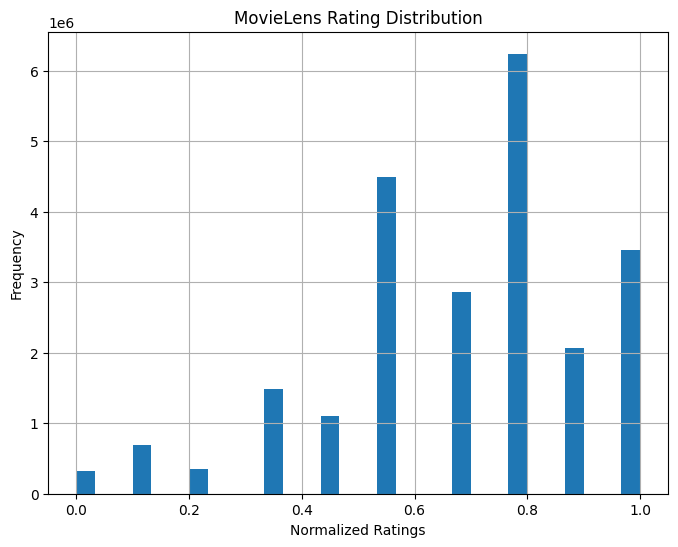

In [6]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Print loader info
def print_loader_info(loader, name):
    for i, (data, mask) in enumerate(loader):
        if i == 0:
            print(f"{name} - First batch info:")
            print(f"Batch shape: {data.shape}")
            print(f"Batch type: {data.dtype}")
            print(f"Mask shape: {mask.shape}")
            print(f"Mask type: {mask.dtype}")
            print(f"Number of samples in batch: {data.size(0)}")
            break

print_loader_info(train_loader, "MovieLens Train Loader")
print_loader_info(val_loader, "MovieLens Validation Loader")
print_loader_info(test_loader, "MovieLens Test Loader")

# Plot the distribution of the data
plt.figure(figsize=(8, 6))
ratings_data['rating'].hist(bins=30)
plt.title('MovieLens Rating Distribution')
plt.xlabel('Normalized Ratings')
plt.ylabel('Frequency')
plt.show()


In [7]:
# Split the data
user_indices = np.arange(user_item_matrix.shape[0])

# Initial split to separate out the test set
train_val_indices, test_indices = train_test_split(user_indices, test_size=0.2, random_state=42)

# Further split the training and validation sets
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.25, random_state=42)

# Verify no overlap between sets
assert len(set(train_indices) & set(val_indices)) == 0, "Overlap between training and validation sets"
assert len(set(train_indices) & set(test_indices)) == 0, "Overlap between training and test sets"
assert len(set(val_indices) & set(test_indices)) == 0, "Overlap between validation and test sets"

print(f"Training set size: {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")
print(f"Test set size: {len(test_indices)}")


Training set size: 97523
Validation set size: 32508
Test set size: 32508


In [8]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

class SimpleAutoRec(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleAutoRec, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [9]:
def masked_mse_loss(output, target, mask):
    loss = ((output - target) ** 2) * mask
    return loss.sum() / mask.sum()


In [10]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler, device):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, genuine_mask) in enumerate(train_loader):
            data = data.to(device)
            genuine_mask = genuine_mask.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, data, genuine_mask)  # Use the custom masked MSE loss
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Adjust the learning rate
        scheduler.step()

        # Calculate average training loss for the epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, genuine_mask in val_loader:
                data = data.to(device)
                genuine_mask = genuine_mask.to(device)

                output = model(data)
                loss = criterion(output, data, genuine_mask)  # Use the custom masked MSE loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses


In [11]:
# Example usage
input_dim = user_item_matrix.shape[1]  # Number of items
hidden_dim = 512  # Single hidden layer size
device = torch.device('cpu')

model = SimpleAutoRec(input_dim=input_dim, hidden_dim=hidden_dim).to(device)

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Example Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [12]:
num_epochs = 15
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, masked_mse_loss, optimizer, scheduler, device)

Epoch [1/15], Batch [100/762], Loss: 0.0616
Epoch [1/15], Batch [200/762], Loss: 0.0483
Epoch [1/15], Batch [300/762], Loss: 0.0436
Epoch [1/15], Batch [400/762], Loss: 0.0435
Epoch [1/15], Batch [500/762], Loss: 0.0471
Epoch [1/15], Batch [600/762], Loss: 0.0470
Epoch [1/15], Batch [700/762], Loss: 0.0397
Epoch 1/15, Train Loss: 0.0563, Validation Loss: 0.0407
Epoch [2/15], Batch [100/762], Loss: 0.0415
Epoch [2/15], Batch [200/762], Loss: 0.0435
Epoch [2/15], Batch [300/762], Loss: 0.0392
Epoch [2/15], Batch [400/762], Loss: 0.0383
Epoch [2/15], Batch [500/762], Loss: 0.0373
Epoch [2/15], Batch [600/762], Loss: 0.0389
Epoch [2/15], Batch [700/762], Loss: 0.0364
Epoch 2/15, Train Loss: 0.0378, Validation Loss: 0.0373
Epoch [3/15], Batch [100/762], Loss: 0.0319
Epoch [3/15], Batch [200/762], Loss: 0.0348
Epoch [3/15], Batch [300/762], Loss: 0.0320
Epoch [3/15], Batch [400/762], Loss: 0.0335
Epoch [3/15], Batch [500/762], Loss: 0.0314
Epoch [3/15], Batch [600/762], Loss: 0.0336
Epoch [3

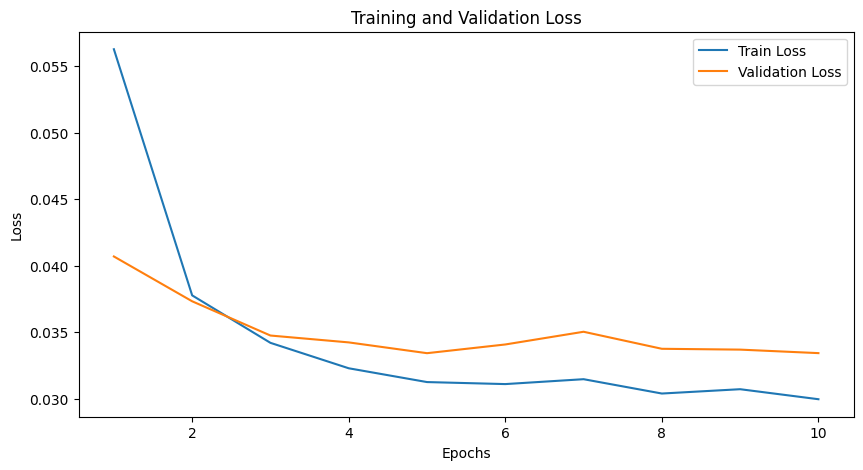

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

                                             title  OriginalRating   
0                              Pulp Fiction (1994)        1.000000  \
1                                       Ran (1985)        1.000000   
2                                   Gattaca (1997)        1.000000   
3                              Moulin Rouge (2001)        0.555556   
4    Lord of the Rings: The Two Towers, The (2002)        0.777778   
..                                             ...             ...   
642                       Blade Runner 2049 (2017)        0.888889   
643                Star Wars: The Last Jedi (2017)        0.666667   
644                                  Bright (2017)        0.555556   
645                           Incredibles 2 (2018)        0.666667   
646                              Deadpool 2 (2018)        0.888889   

     PredictedRating  
0           0.939278  
1           0.786892  
2           0.753230  
3           0.676875  
4           0.824345  
..               ... 

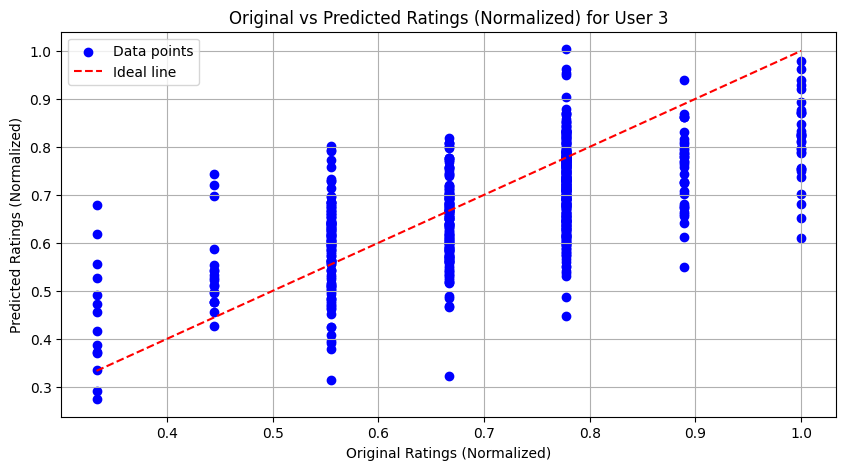

In [17]:
# Function to compare predicted and actual ratings for a specific user
def compare_user_ratings_normalized(user_id, model, device):
    model.eval()
    with torch.no_grad():
        user_idx = original_to_factorized_user_id(user_id)
        if user_idx is not None:
            user_data = user_item_matrix.getrow(user_idx).toarray().flatten()
            user_mask = genuine_ratings_mask.getrow(user_idx).toarray().flatten()
            user_tensor = torch.from_numpy(user_data).float().to(device).unsqueeze(0)
            user_mask_tensor = torch.from_numpy(user_mask).float().to(device).unsqueeze(0)

            user_output = model(user_tensor).cpu().numpy().flatten()
            user_ratings = user_tensor.cpu().numpy().flatten()

            # Filter only the movies that the user has rated
            reviewed_indices = np.where(user_mask > 0)[0]
            original_ratings = user_ratings[reviewed_indices]
            predicted_ratings = user_output[reviewed_indices]

            df = pd.DataFrame({
                'MovieID': reviewed_indices,
                'OriginalRating': original_ratings,
                'PredictedRating': predicted_ratings
            })

            # Map factorized movie IDs back to original IDs
            df['MovieID'] = df['MovieID'].apply(lambda x: factorized_to_original_movie_id(x))

            # Add movie titles
            df = df.merge(movies_data, left_on='MovieID', right_on='movieId')[['title', 'OriginalRating', 'PredictedRating']]

            # Print the comparison
            print(df)

            # Plot the comparison
            plt.figure(figsize=(10, 5))
            plt.scatter(df['OriginalRating'], df['PredictedRating'], color='blue', label='Data points')
            plt.plot([df['OriginalRating'].min(), df['OriginalRating'].max()],
                     [df['OriginalRating'].min(), df['OriginalRating'].max()], 'r--', label='Ideal line')
            plt.xlabel('Original Ratings (Normalized)')
            plt.ylabel('Predicted Ratings (Normalized)')
            plt.title(f'Original vs Predicted Ratings (Normalized) for User {user_id}')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"User ID {user_id} not found.")

# Compare predicted and actual ratings for the specific user with normalized values
compare_user_ratings_normalized(3, model, device)


In [15]:
torch.save(model.state_dict(), 'movielens_simple_autoencoder.pth')

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, data_loader, device):
    model.eval()
    actual_ratings = []
    predicted_ratings = []

    with torch.no_grad():
        for data, mask in data_loader:
            data = data.to(device)
            mask = mask.to(device)

            output = model(data)
            actual_ratings.extend(data[mask > 0].cpu().numpy())
            predicted_ratings.extend(output[mask > 0].cpu().numpy())

    actual_ratings = np.array(actual_ratings)
    predicted_ratings = np.array(predicted_ratings)

    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    mae = mean_absolute_error(actual_ratings, predicted_ratings)

    return rmse, mae

train_rmse, train_mae = evaluate_model(model, train_loader, device)
val_rmse, val_mae = evaluate_model(model, val_loader, device)
test_rmse, test_mae = evaluate_model(model, test_loader, device)

print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}, Validation MAE: {val_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')


Train RMSE: 0.1672, Train MAE: 0.1283
Validation RMSE: 0.1829, Validation MAE: 0.1409
Test RMSE: 0.1824, Test MAE: 0.1404


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate the completed matrix with predicted ratings
def generate_completed_matrix(model, user_item_matrix, device):
    model.eval()
    with torch.no_grad():
        # Convert the entire user-item matrix to a tensor and move it to the device
        user_item_tensor = torch.from_numpy(user_item_matrix.toarray()).float().to(device)
        
        # Pass the tensor through the model to get predicted ratings
        outputs = model(user_item_tensor)
        if isinstance(outputs, tuple):
            reconstructed_tensor = outputs[0]
        else:
            reconstructed_tensor = outputs
        
        # Move the reconstructed tensor back to CPU and convert to numpy array
        predicted_tensor = reconstructed_tensor.cpu().numpy()
        
        return predicted_tensor

# Generate the completed matrix with predicted ratings
completed_matrix = generate_completed_matrix(model, user_item_matrix, device)

# Flatten the completed matrix to get all predicted ratings
predicted_ratings = completed_matrix.flatten()

# Plot the distribution of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(predicted_ratings, bins=30, edgecolor='black')
plt.title('Distribution of Predicted Ratings -')
plt.xlabel('Predicted Ratings (Normalized)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

hyperparameter tuning

In [20]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import itertools
import random

# Define SimpleAutoRec model
class SimpleAutoRec(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleAutoRec, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def masked_mse_loss(output, target, mask):
    loss = ((output - target) ** 2) * mask
    return loss.sum() / mask.sum()

def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler, device):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, genuine_mask) in enumerate(train_loader):
            data = data.to(device)
            genuine_mask = genuine_mask.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, data, genuine_mask)  # Use the custom masked MSE loss
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Adjust the learning rate
        scheduler.step()

        # Calculate average training loss for the epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, genuine_mask in val_loader:
                data = data.to(device)
                genuine_mask = genuine_mask.to(device)

                output = model(data)
                loss = criterion(output, data, genuine_mask)  # Use the custom masked MSE loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses

# Define hyperparameter grid
hyperparameter_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'hidden_dim': [64, 128, 256],
    'batch_size': [32, 64, 128]
}

# Define K-Fold Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Function to evaluate model performance using k-fold cross-validation
def k_fold_cv(hyperparams, kf, train_dataset, device):
    input_dim = train_dataset[0][0].shape[0]  # Input dimension

    learning_rate = hyperparams['learning_rate']
    hidden_dim = hyperparams['hidden_dim']
    batch_size = hyperparams['batch_size']

    val_losses = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(np.arange(len(train_dataset)))):
        print(f"Processing fold {fold + 1}/{kf.n_splits} with hyperparameters: {hyperparams}")

        train_subset = Subset(train_dataset, train_indices)
        val_subset = Subset(train_dataset, val_indices)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size)
        
        model = SimpleAutoRec(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Train the model
        num_epochs = 10
        train_model(model, train_loader, val_loader, num_epochs, masked_mse_loss, optimizer, scheduler, device)
        
        # Evaluate on validation set
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data, genuine_mask in val_loader:
                data = data.to(device)
                genuine_mask = genuine_mask.to(device)

                output = model(data)
                loss = masked_mse_loss(output, data, genuine_mask)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Fold {fold + 1} Validation Loss: {val_loss:.4f}")

    return np.mean(val_losses)

# Perform grid search (but not for too many configurations)
# Define the number of random samples to draw from the hyperparameter grid
num_samples = 10

# Create a list of all possible hyperparameter combinations
all_combinations = list(itertools.product(*hyperparameter_grid.values()))

# Randomly select a subset of the hyperparameter combinations
random_combinations = random.sample(all_combinations, num_samples)

best_score = float('inf')
best_params = None

for param_combination in random_combinations:
    hyperparams = dict(zip(hyperparameter_grid.keys(), param_combination))
    print(f"Evaluating hyperparameters: {hyperparams}")
    avg_val_loss = k_fold_cv(hyperparams, kf, train_dataset, device)
    
    if avg_val_loss < best_score:
        best_score = avg_val_loss
        best_params = hyperparams

    print(f"Current best validation loss: {best_score:.4f} with hyperparameters: {best_params}")

print("Best hyperparameters:", best_params)
print("Best validation loss:", best_score)


Evaluating hyperparameters: {'learning_rate': 0.01, 'hidden_dim': 128, 'batch_size': 64}
Processing fold 1/3 with hyperparameters: {'learning_rate': 0.01, 'hidden_dim': 128, 'batch_size': 64}
Epoch [1/10], Batch [100/1016], Loss: 0.0679
Epoch [1/10], Batch [200/1016], Loss: 0.0731
Epoch [1/10], Batch [300/1016], Loss: 0.0630
Epoch [1/10], Batch [400/1016], Loss: 0.0486
Epoch [1/10], Batch [500/1016], Loss: 0.0446
Epoch [1/10], Batch [600/1016], Loss: 0.0417
Epoch [1/10], Batch [700/1016], Loss: 0.0510
Epoch [1/10], Batch [800/1016], Loss: 0.0392
Epoch [1/10], Batch [900/1016], Loss: 0.0526
Epoch [1/10], Batch [1000/1016], Loss: 0.0396
Epoch 1/10, Train Loss: 0.0579, Validation Loss: 0.0448
Epoch [2/10], Batch [100/1016], Loss: 0.0434
Epoch [2/10], Batch [200/1016], Loss: 0.0385
Epoch [2/10], Batch [300/1016], Loss: 0.0412
Epoch [2/10], Batch [400/1016], Loss: 0.0381
Epoch [2/10], Batch [500/1016], Loss: 0.0518
Epoch [2/10], Batch [600/1016], Loss: 0.0534
Epoch [2/10], Batch [700/1016],

In [21]:
num_epochs = 15
input_dim = user_item_matrix.shape[1]  # Number of items
hidden_dim = 256  # best hidden dim
device = torch.device('cpu')

model = SimpleAutoRec(input_dim=input_dim, hidden_dim=hidden_dim).to(device)

learning_rate = 0.001 #best
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Example Dataloaders
batch_size-128 #best
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, masked_mse_loss, optimizer, scheduler, device)

Epoch [1/15], Batch [100/762], Loss: 0.0718
Epoch [1/15], Batch [200/762], Loss: 0.0545
Epoch [1/15], Batch [300/762], Loss: 0.0507
Epoch [1/15], Batch [400/762], Loss: 0.0462
Epoch [1/15], Batch [500/762], Loss: 0.0442
Epoch [1/15], Batch [600/762], Loss: 0.0418
Epoch [1/15], Batch [700/762], Loss: 0.0413
Epoch 1/15, Train Loss: 0.0592, Validation Loss: 0.0429
Epoch [2/15], Batch [100/762], Loss: 0.0408
Epoch [2/15], Batch [200/762], Loss: 0.0388
Epoch [2/15], Batch [300/762], Loss: 0.0471
Epoch [2/15], Batch [400/762], Loss: 0.0427
Epoch [2/15], Batch [500/762], Loss: 0.0368
Epoch [2/15], Batch [600/762], Loss: 0.0399
Epoch [2/15], Batch [700/762], Loss: 0.0364
Epoch 2/15, Train Loss: 0.0402, Validation Loss: 0.0386
Epoch [3/15], Batch [100/762], Loss: 0.0395
Epoch [3/15], Batch [200/762], Loss: 0.0360
Epoch [3/15], Batch [300/762], Loss: 0.0355
Epoch [3/15], Batch [400/762], Loss: 0.0369
Epoch [3/15], Batch [500/762], Loss: 0.0382
Epoch [3/15], Batch [600/762], Loss: 0.0359
Epoch [3

In [22]:
torch.save(model.state_dict(), 'movielens_simple_autoencoder_best_param.pth')

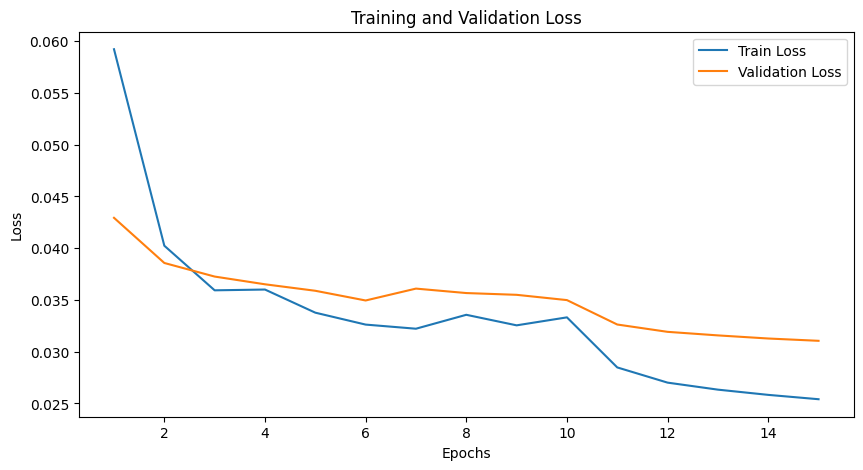

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

                                             title  OriginalRating   
0                              Pulp Fiction (1994)        1.000000  \
1                                       Ran (1985)        1.000000   
2                                   Gattaca (1997)        1.000000   
3                              Moulin Rouge (2001)        0.555556   
4    Lord of the Rings: The Two Towers, The (2002)        0.777778   
..                                             ...             ...   
642                       Blade Runner 2049 (2017)        0.888889   
643                Star Wars: The Last Jedi (2017)        0.666667   
644                                  Bright (2017)        0.555556   
645                           Incredibles 2 (2018)        0.666667   
646                              Deadpool 2 (2018)        0.888889   

     PredictedRating  
0           0.962327  
1           0.856859  
2           0.877982  
3           0.726741  
4           0.916316  
..               ... 

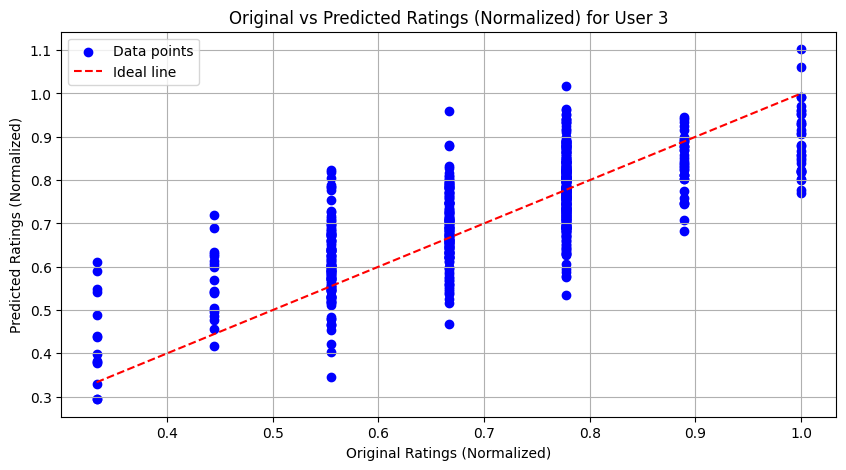

In [26]:

# Compare predicted and actual ratings for the specific user with normalized values
compare_user_ratings_normalized(3, model, device)


In [27]:
train_rmse, train_mae = evaluate_model(model, train_loader, device)
val_rmse, val_mae = evaluate_model(model, val_loader, device)
test_rmse, test_mae = evaluate_model(model, test_loader, device)

print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}, Validation MAE: {val_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

Train RMSE: 0.1574, Train MAE: 0.1200
Validation RMSE: 0.1763, Validation MAE: 0.1349
Test RMSE: 0.1759, Test MAE: 0.1346


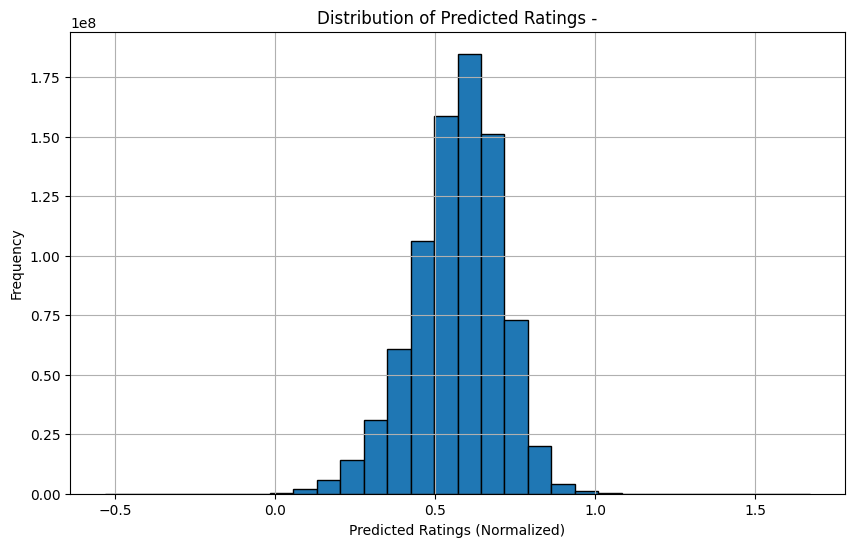

In [28]:
# Generate the completed matrix with predicted ratings
completed_matrix = generate_completed_matrix(model, user_item_matrix, device)

# Flatten the completed matrix to get all predicted ratings
predicted_ratings = completed_matrix.flatten()

# Plot the distribution of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(predicted_ratings, bins=30, edgecolor='black')
plt.title('Distribution of Predicted Ratings -')
plt.xlabel('Predicted Ratings (Normalized)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
